# Predicting hotel booking cancellations

Data taken from https://www.kaggle.com/jessemostipak/hotel-booking-demand

## Goal:
Predict hotel bookings that are at a high risk of cancellation, so that hotel owners may strategically double-book or take proactive steps (e.g. reminding guests) to keep close to full capacity.

## Approach:
1. Look at structure of data, and what's included
2. Find a few variables that are correlated with cancellations
3. Build a prototype to show proof of concept
4. Go through everything properly and build a good quality model
5. Investigate the implications of the data

Steps 4 and 5 will be in another notebook since that's where most of the work will be

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import os

data = pd.read_csv('hotel_bookings.csv')

In [2]:
### Observations:
# Data has 32 columns x 119390 rows
# Nulls:
#    4 in "children", 488 in "country", 16340 in "agent", 112593 in "company"

## dtypes:
# numerical:
#    lead_time, arrival_date_year, arrival_date_week_number, arrival_date_day_of_month, stays_in_weekend_nights,
#    stays_in_week_nights, adults, children, babies, previous_cancellations, previous_bookings_not_canceled, 
#    booking_changes, agent, company, days_in_waiting_list, adr, required_car_parking_spaces, total_of_special_requests,
# binary:
#    is_canceled, is_repeated_guest
# string/categorical:
#    hotel, arrival_date_month, meal, country, market_segment, distribution_channel, 
#    reserved_room_type, assigned_room_type, deposit_type, customer_type, reservation_status
# date:
#    reservation_status_date

# data.head()
data.describe()
# pd.isnull(data).sum()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


First bookings: 37.8 % cancel
Repeat bookings: 14.5 % cancel


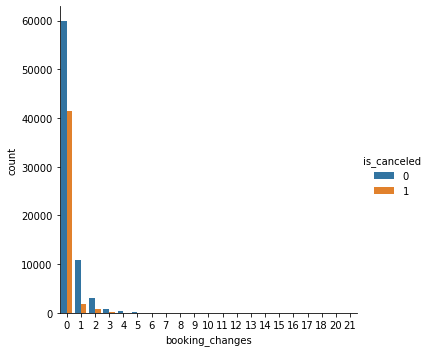

In [3]:
## Which variables are correlated with cancellations?
# Important:
#    previous_cancellations, is_repeated_guest, lead_time, hotel
# Not so important: 
#    date, stay length, children, babies

# print(X.shape,y.shape)

# pd.plotting.scatter_matrix(X_train, c=y_train, figsize=(15, 15), marker='o',
#                                  hist_kwds={'bins': 20}, s=60, alpha=.8)
# sn.pairplot(data_plot,hue='is_canceled',vars=['children',
#                                         'lead_time','adr'])

# sn.catplot(x="is_canceled",y="lead_time",data=data,kind="violin")
# sn.catplot(x="hotel",y="is_canceled",data=data,kind="violin")
# sn.catplot(x="adults",y="hotel",hue="is_canceled",data=data,kind="violin")
# sn.catplot(x="booking_changes",hue="is_canceled",data=data,kind="count")

#####  Numerically check if each categorical column contains significant info by itself
# Does:
#    is_repeated_guest, meal, arrival_date_month, market_segment, distribution_channel (but almost same as market segment)
#    assigned_room_type, booking_changes (0 vs >0), required_car_parking_spaces
#    
# Doesnt:
#    arrival_date_year, reserved_room_type, deposit_type


var = 'market_segment'
vals = data[var].unique()
vals.sort()
if len(vals) > 80:
    print('too many vars!')
    print(vals)
    raise Exception()
for v in vals:
    query = var+' == '+str(v)
#     pos = data.query(query)
    pos = data[data[var]==v]
    n_cancel = len(pos.query('is_canceled == 1'))
    print(query+':',np.round(100*n_cancel/len(pos),1),'%','from',len(pos))

In [4]:
# Is there a class imbalance?
# Yes, but it's not too bad!
# Might still want to oversample or undersample to 
n_canceled = sum(data["is_canceled"] == 1)
n_didnt = sum(data["is_canceled"] == 0)
n_missing = sum(data["is_canceled"].isnull())
print('Cancelled, didnt, missing:')
print(n_canceled,n_didnt,n_missing)

Cancelled, didnt, missing:
44224 75166 0


## Prototype:
Using a few columns that I found were important, I will make a few simple models using Linear Regression and Random Forest. The goal is to see what accuracy I can get without much work so that I have a point of reference for the full model when deciding when to call it done, and to investigate what kinds of errors this model makes (e.g. are there a lot of false positives?)

In [5]:
# I'll use 70% of the data, so I have a similar amount to the full model I'll make later
from sklearn.model_selection import train_test_split
y = (data['is_canceled'] == 1)
X = data.drop('is_canceled',axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7)

In [6]:
# Take a few variables to prototype on
# The first 5 were very important as seen in the plots earlier. The next two are just easy to include
used_vars = ['lead_time','hotel','is_repeated_guest','previous_cancellations','booking_changes',
            'adults','arrival_date_week_number']

def preprocess(X):
    # Remove unused variables
    X = X[used_vars]

    # Hotel can be transformed to a binary
    if 'hotel' in X.keys():
        is_resort = (X['hotel'] == 'Resort Hotel')
        X.insert(1,'is_resort',is_resort)
        X = X.drop(['hotel'],axis=1)
    
    return X

X_train = preprocess(X_train)
X_test = preprocess(X_test)

In [7]:
# Build a simple logistic regression from a few variables
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# model = LogisticRegression(fit_intercept=True,penalty='l2',solver='lbfgs',max_iter=1000) #F1 = 0.46 on train with 6-fold CV
model = RandomForestClassifier(n_estimators=100,min_samples_leaf=10) # F1=0.62 on train with 6-fold CV

model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

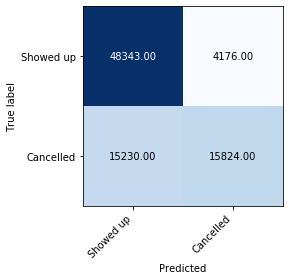

Accuracy score (training) 0.767795819223912
F1 score (training): 0.6198926626708976
Recall (training): 0.5095639853159013
Precision (training): 0.7912


In [8]:
# Accuracy and confusion matrix
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix,recall_score,precision_score,f1_score,accuracy_score
from hotel_modules import plot_confusion_matrix
y_train_pred = cross_val_predict(model,X_train,y_train,cv=6)
conf_mx = confusion_matrix(y_train,y_train_pred)
plot_confusion_matrix(conf_mx,cats = ['Showed up','Cancelled'])

f1 = f1_score(y_train,y_train_pred)
print('Accuracy score (training)',accuracy_score(y_train,y_train_pred))
print('F1 score (training):',f1)
print('Recall (training):',recall_score(y_train,y_train_pred))
print('Precision (training):',precision_score(y_train,y_train_pred))

## Takeaways:
- A simple model does have some predictive power.
- Random Forest performs significantly better than Logistic Regression, suggesting that perhaps some features are nonlinear in the log-odds or correlated.
- Recall was poor (i.e. lots of false negatives) and I should monitor it in particular. However in a real-world scenario, if a client wants to take proactive action to send reminders to high-risk bookings or charge them a deposit.